In [10]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
#sc = SparkContext(master="local[4]").getOrCreate()
sc = SparkSession.builder.master("local[4]").getOrCreate()

In [ ]:
import numpy as np

TOTAL = 1000000
dots = sc.parallelize([2.0 * np.random.random(2) - 1.0
                       for i in range(TOTAL)]) \
         .cache()
print("Number of random points:", dots.count())

stats = dots.stats()
print('Mean:', stats.mean())
print('stdev:', stats.stdev())
print(dots.take(5))

In [ ]:
from operator import itemgetter

# x.itemgetter(a) - fetches value at location a, assuming x is just an iterable (e.g. list)
# sample.map(itemgetter(a)) - returns a new RDD object by applying itemgetter(a) to every element in sample
# sample.map(itemgetter(a)).collect() - Takes the RDD object and returns it as a python list
type(dots.map(itemgetter(0)))

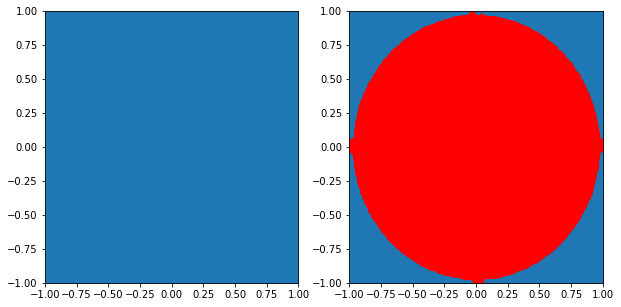

In [11]:
%matplotlib inline
from operator import itemgetter
from matplotlib import pyplot as plt

plt.figure(figsize = (10, 5))

# Plot 1
plt.subplot(1, 2, 1)
plt.xlim((-1.0, 1.0))
plt.ylim((-1.0, 1.0))

sample = dots.sample(False, 0.1)
X = sample.map(itemgetter(0)).collect()
Y = sample.map(itemgetter(1)).collect()
plt.scatter(X, Y)

# Plot 2
plt.subplot(1, 2, 2)
plt.xlim((-1.0, 1.0))
plt.ylim((-1.0, 1.0))

inCircle = lambda v: np.linalg.norm(v) <= 1.0
dotsIn = sample.filter(inCircle).cache()
dotsOut = sample.filter(lambda v: not inCircle(v)).cache()

# inside circle
Xin = dotsIn.map(itemgetter(0)).collect()
Yin = dotsIn.map(itemgetter(1)).collect()
plt.scatter(Xin, Yin, color = 'r')

# outside circle
Xout = dotsOut.map(itemgetter(0)).collect()
Yout = dotsOut.map(itemgetter(1)).collect()
plt.scatter(Xout, Yout)

In [12]:
pi = 4.0 * (dots.filter(inCircle).count()*1.0 / TOTAL)
print("The estimation of \pi is:", pi)

The estimation of \pi is: 3.14178


In [13]:
# Simple operations on plain RDDs
print(sc.parallelize(range(4)).collect()) # Get original RDD back as a list
print(sc.parallelize(range(4)).count())   # Count the number of elements in an RDD
A = sc.parallelize(range(50000000))              # Define a function that generates an RDD
A.reduce(lambda x, y: x+y)                # Use a reduce operation to sum of values of that RDD one at a time.  

[0, 1, 2, 3]
4


1249999975000000

In [14]:
# Examples of (key, value) RDDs
database = sc.parallelize([
    (55632, {'name': 'yoav',  'city': 'jerusalem'} )
    ,(3342, {'name': 'homer', 'town': 'springfield'})])
print(database)
print(database.collect())

print("")
A = sc.parallelize(range(4)).map(lambda x: (x, x*x))
print(A)
print(A.collect())

print("")
A = sc.parallelize([(1,3),(4,100),(1,-5),(3,2)])
print(A)
A = A.reduceByKey(lambda x,y: x*y)
print (A)
print(A.collect())

# Should really be doing large iterations this with an iterator, not a regular list
# for x in xrange(1000000):



ParallelCollectionRDD[19] at parallelize at PythonRDD.scala:184
[(55632, {'name': 'yoav', 'city': 'jerusalem'}), (3342, {'name': 'homer', 'town': 'springfield'})]

PythonRDD[21] at RDD at PythonRDD.scala:49
[(0, 0), (1, 1), (2, 4), (3, 9)]

ParallelCollectionRDD[22] at parallelize at PythonRDD.scala:184
PythonRDD[27] at RDD at PythonRDD.scala:49
[(4, 100), (1, -15), (3, 2)]


In [15]:
# Quiz 1.2 - Given a list l of integers, which of the following 
# expressions compute the average of the elements in the list?
from functools import reduce
l = [1,2,3,4,5,10]

# Create an iterator that's a bunch of 1's the length of the list:
#    ones: map(lambda x: 1, l)
# Sum over that iterator: 
#    denominator =reduce(lambda x, y: x+y, ones)
# Sum over the value of the items in the list: 
#     numerator = reduce(lambda x, y: x+y, l)
# Divide them to get the mean:
#     print(numerator / denominator)

reduce(lambda x, y: x+y, l) / reduce(lambda x, y: x+y, map(lambda x: 1, l))

4.166666666666667

### Week 1, part 2 of 2

# Shortest word in a list


In [16]:
words = {'this', 'is', 'the', 'best', 'mac', 'ever'}
wordRdd = sc.parallelize(words)
wordRdd.reduce(lambda w, v: w if len(w)<len(v) else v)

'is'

#### Custom functions in a reduce statement

In [17]:
# Last lexigraphical word among the longest words
words = {'this', 'is', 'the', 'best', 'mac', 'ever'}
def largerThan(x, y):
    if len(x) > len(y): return x
    elif len(y) > len(x): return y
    else: 
        if x > y:
            return x
        else:
            return y
wordRdd = sc.parallelize(words)
wordRdd.reduce(largerThan)

'this'

#### Spark Worker Optimization

Should see the most optimization when using a multiple of the number of logical cores on the machine

In [15]:
from time import time
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc.stop()
for j in range(1, 10):
    sc = SparkContext(master="local[%d]"%(j)).getOrCreate()
    t0 = time()
    for i in range(10):
        sc.parallelize([1,2]*100000).reduce(lambda x,y:x+y)
    print("{} executors, time = {}".format(j, time()-t0))
    sc.stop()

1 executors, time = 1.9622411727905273
2 executors, time = 1.347442865371704
3 executors, time = 1.504870891571045
4 executors, time = 1.3910601139068604
5 executors, time = 1.4167201519012451
6 executors, time = 1.797271728515625
7 executors, time = 1.726923942565918
8 executors, time = 1.6213691234588623
9 executors, time = 1.6341488361358643


#### See the effect of Lazy Evaluation

In [45]:
# New Spark context outside of other cells
sc.stop()
sc = SparkContext(master="local[4]")
RDD=sc.parallelize(range(1000000))

In [46]:
%%time
# Create a dummy function to compute cos(x) from 1 to 100
# Goal is just to take up time
# Note that it takes 420 ms = 13 microseconds
from math import cos
def taketime(i):
    [cos(j) for j in range(100)]
    return cos(i)

CPU times: user 28 µs, sys: 1e+03 ns, total: 29 µs
Wall time: 34.8 µs


In [36]:
%%time
taketime(1) # Taketime is the function that we described above

CPU times: user 21 µs, sys: 1e+03 ns, total: 22 µs
Wall time: 24.1 µs


0.5403023058681398

In [47]:
%%time
# Doing the taketime() on all values in the RDD -- 1 Million values
# Expect it to take 1 Million x 13 microsec = 13 seconds
# But it just takes ~20 microseconds!  
# Because no computation was done -- we just created an execution plan.
# Interm doesn't point to an RDD in memory.
# It just points to an execution plan in a dependence graph.

Interm=RDD.map(lambda x: taketime(x))

CPU times: user 32 µs, sys: 1 µs, total: 33 µs
Wall time: 38.9 µs


In [35]:
print(Interm.toDebugString().decode())

(4) PythonRDD[2] at RDD at PythonRDD.scala:49 []
 |  ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:184 []


##### Execute the Map without and with Caching

In [48]:
%%time
# Takes 8 seconds, << the 13 seconds we expected
print('out=',Interm.reduce(lambda x, y: x+y))

out= -0.2887054679684655
CPU times: user 9.96 ms, sys: 5.21 ms, total: 15.2 ms
Wall time: 8.31 s


In [53]:
%%time
print('out=', Interm.filter(lambda x:x>0).count())

out= 500000
CPU times: user 6.19 ms, sys: 2.78 ms, total: 8.97 ms
Wall time: 231 ms


In [55]:
%%time
# Now cache
Interm = RDD.map(lambda x: taketime(x)).cache()

CPU times: user 3.61 ms, sys: 1.69 ms, total: 5.3 ms
Wall time: 9.65 ms


In [42]:
print(Interm.toDebugString().decode())

(4) PythonRDD[5] at RDD at PythonRDD.scala:49 [Memory Serialized 1x Replicated]
 |  ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:184 [Memory Serialized 1x Replicated]


In [52]:
%%time
print('out',Interm.reduce(lambda x, y: x+y))

out -0.2887054679684655
CPU times: user 6.38 ms, sys: 3.06 ms, total: 9.44 ms
Wall time: 219 ms


### Partition and Gloming
- Can specify and RDD when creating a number of partitions
- The default is the number of workers when defined in the SparkContext set up
- You can repartition.  RDD.repartition(n).     Or sc.parallelize(range(10000),slices=10))

#### Partitions
- You need at least as many partitions as workers
  - If you have workers without a partition to work on, then they're idle.
  - I.e. the compute core (a worker) doesn't have anything to do (no data partition to crunch)
- Smaller partitions (i.e. more partitions per unit of data) can allow more parallelization

#### Partitioning and optimization
- Suppose we use filter() to select some elements in A
- Some partitions might have more elements remaining than others
  - Then we'll have partitions with no data, so some workers are functionally idle
- To fix, we need to repartition the RDD

#### .partitionBy(k)
- RDD.partitionBy(k) expects an RDD where the keys are integers
- The element a position (key) is placed into partition number (key % k)
- That predictability gives us control over which elements go into which partition
  - You usually need to think through this!!
  
#### repartition(k)
- Randomly distributes across all k partitions
- Advantages: simple and doesn't require defining a key
- Disadvantages: Lose control of the partitioning, which you may want to know going on

In [59]:
# partitionBy(n) = aim for n equal sized partitions 
# The print statement shows us the size of each partition
A = sc.parallelize(range(1000000))\
    .map(lambda x:(x,x)).partitionBy(10)
print(A.glom().map(len).collect())

[100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000, 100000]


In [61]:
# select 20% of the entries
B = A.filter(lambda pair: pair[0]%5==0)
# get the number of partitions
print(B.glom().map(len).collect())

[100000, 0, 0, 0, 0, 100000, 0, 0, 0, 0]


In [64]:
# We want to repartition across all n workers -- suppose n = 10
# All of our keys and values are multiples of 5.
# Since our values are integers, we can make the key equal to the value divided by 10
# It will automatically round the key, then we partitionBy(10)) again
C = B.map(lambda pair:(pair[1]/10, pair[1])).partitionBy(10)
print(C.glom().map(len).collect())

[20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000]


#### glom() explanation
- In general, Spark does not allow the worker to refer to specific elements of the RDD
- However, glom() transforms each partition into a tuple of elements
  - glom() creates an RDD of tuples
  - one tuple per partition -- i.e. all data on the partition is contained in a tuple
  - Workers can then refer to elements by their index in the tuple
  - But you still can't assign values to particular elements because RDDs are still immutable
  
#### glom()'s uses
- C.glom().map(len).collect()
  - C.glom() creates a tuple on each partition
  - .map(len) applies the len operation to each partition (still as an RDD)
  - .collect() materializes that result into a list
  
- Any time that you want to care what's in your partition (see example below)

In [71]:
# Fun test example of glom() -- returns some info about the RDD when the partition is blank
def getPartitionInfo(G):
    d=0
    if len(G)>1: 
        for i in range(len(G)-1):
            d+=abs(G[i+1][1] - G[i][1]) # Access the glom'd RDD now that it's a tuple
        return (G[0][0], len(G), d)
    else:
        return(None)
    
output=B.glom().map(lambda B: getPartitionInfo(B)).collect()
print(output)

[(0, 100000, 999990), None, None, None, None, (5, 100000, 999990), None, None, None, None]
